In [1]:
%matplotlib inline
import re
import nltk
import gensim
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
from sklearn.feature_extraction.text import TfidfTransformer

C:\Users\Arjun\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
df = pd.read_excel("facilities dataset/Facility_Report_with_Topics.xlsx")

In [5]:
df.describe()

,Charge Type,Days to Estimate Completed,Labor Hours,FM Labor,Flat Bill,Warehouse Parts,NonStock Received and Invoiced,NonStock Received Not Invoiced,NonStock On Order Not Received,Total
count,0.0,1617.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000
mean,NaN,10.652443,1.413789,20.557774,0.656808,4.897779,90.875005,0.413742,7.205234,124.606343
std,NaN,20.930736,9.994488,209.774800,23.112760,244.264626,3134.933050,77.732236,583.620030,3305.860326
min,NaN,-50.000000,-25.000000,-373.760000,0.000000,0.000000,-694.000000,0.000000,0.000000,-674.370000
25%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,5.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.680000
max,NaN,390.000000,2021.000000,38561.290000,6982.250000,65814.820000,885984.020000,35577.560000,163675.000000,885984.020000


In [6]:
len(df)

268526

In [7]:
list(df)

['Work Order',
 'WO Type',
 'Charge Type',
 'Reference Number',
 'Project',
 'Action Requested',
 'Priority',
 'Status',
 'Requestor',
 'Req Phone',
 'Department',
 'Dept Number',
 'Account Number(s)',
 'Campus',
 'Building',
 'Floor',
 'Area',
 'Area Function',
 'Area Type',
 'Object Type',
 'WO Object',
 'Date Requested',
 'Date Estimate Began',
 'Date Estimate Was Completed',
 'Days to Estimate Completed',
 'Date WO Issued',
 'Days to Issue',
 'Scheduled Start Date',
 'Date Funded',
 'Funded Amount',
 'First Charge',
 'Days to Start',
 'Scheduled Completion Date',
 'Date Finished',
 'Days to Finish',
 'Date Completed',
 'Days to Completion',
 'Labor Hours',
 'FM Labor',
 'Flat Bill',
 'Warehouse Parts',
 'NonStock Received and Invoiced',
 'NonStock Received Not Invoiced',
 'NonStock On Order Not Received',
 'Total',
 'Assigned Trades',
 'General Comments',
 'Task Comments',
 'Topics']

In [12]:
len(df[df['Topics'].str.contains("Topic 89")])

8078

In [13]:
hvac_df = df[df['Topics'].str.contains("Topic 89")]
len(hvac_df)

8078

In [14]:
hvac_df.describe()

,Charge Type,Days to Estimate Completed,Labor Hours,FM Labor,Flat Bill,Warehouse Parts,NonStock Received and Invoiced,NonStock Received Not Invoiced,NonStock On Order Not Received,Total
count,0.0,25.000000,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000
mean,NaN,33.040000,3.267322,50.650115,0.063011,15.779007,212.796663,1.241523,29.692570,310.222888
std,NaN,28.395246,7.896953,194.314083,5.238983,625.808383,2676.994380,42.746115,814.532211,3690.571225
min,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,-353.430000,0.000000,0.000000,-131.950000
25%,NaN,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,22.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,50.000000,3.000000,23.360000,0.000000,0.000000,0.000000,0.000000,0.000000,69.830000
max,NaN,104.000000,160.250000,4383.680000,470.000000,51243.670000,140047.500000,2896.360000,55691.450000,247696.820000


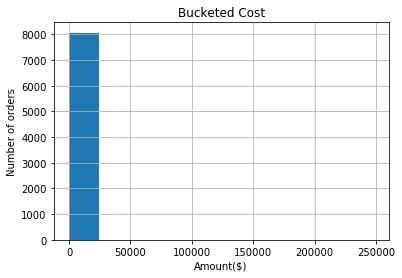

In [19]:
cost_plot = hvac_df['Total'].hist()
cost_plot.set_title("Bucketed Cost")
cost_plot.set_xlabel("Amount($)")
cost_plot.set_ylabel("Number of orders")

In [47]:
print(len(hvac_df[hvac_df['Total'] < 1200]))
print(hvac_df.Total.quantile(0.98))

7762
2312.230600000001


In [51]:
cutoff_cost = hvac_df.Total.quantile(0.98)
total_bins = 10
high_cost_hvac_issues = hvac_df[hvac_df['Total'] >= cutoff_cost]
print("High cost HVAC issues", len(high_cost_hvac_issues))

zero_hvac_issues = hvac_df[hvac_df['Total'] == 0]
print("Zero cost HVAC issues", len(zero_hvac_issues))

low_cost_hvac_issues = hvac_df[hvac_df['Total'] > 0]
low_cost_hvac_issues = low_cost_hvac_issues[low_cost_hvac_issues['Total'] < cutoff_cost]
print("Low cost HVAC issues", len(low_cost_hvac_issues))

High cost HVAC issues 162
Zero cost HVAC issues 4665
Low cost HVAC issues 3249


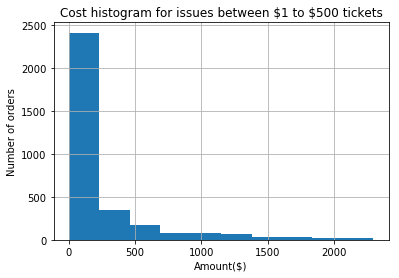

In [57]:
cost_plot = low_cost_hvac_issues['Total'].hist(bins=total_bins)
cost_plot.set_title("Cost histogram for issues in low cost tickets")
cost_plot.set_xlabel("Amount($)")
cost_plot.set_ylabel("Number of orders")

In [58]:
print(cutoff_cost)

2312.230600000001


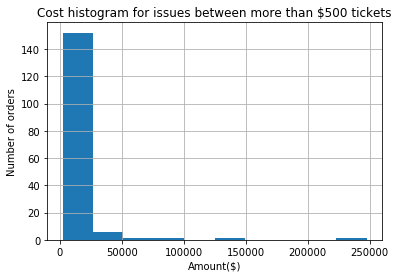

In [53]:
high_cost_plot = high_cost_hvac_issues['Total'].hist(bins=total_bins)
high_cost_plot.set_title("Cost histogram for issues for high cost tickets")
high_cost_plot.set_xlabel("Amount($)")
high_cost_plot.set_ylabel("Number of orders")

In [56]:
pd.cut(low_cost_hvac_issues['Total'], total_bins).value_counts().sort_index()

(-2.288, 229.847]       2407
(229.847, 459.684]       349
(459.684, 689.521]       174
(689.521, 919.358]        78
(919.358, 1149.195]       74
(1149.195, 1379.032]      72
(1379.032, 1608.869]      34
(1608.869, 1838.706]      28
(1838.706, 2068.543]      16
(2068.543, 2298.38]       17
Name: Total, dtype: int64

In [63]:
total_bins = 10
low_cost_hvac_issues['bin'] = low_cost_hvac_issues['Total'] // (cutoff_cost / total_bins)

In [82]:
testdf = pd.read_excel(r"C:\Users\Arjun\Desktop\test.xlsx", header=None)
for d in testdf.groupby(0):
    print(list(d))
    print(d[0], '--> ',' '.join(d[1][1]))
    print('*********************')

# print('. '.join(d[1]) for d in low_cost_hvac_issues.groupby(['bin'])['Action Requested'])

[1,    0      1   2
0  1     hi  10
4  1  there  50]
1 -->  hi there
*********************
[2,    0      1   2
3  2  whats  40
5  2     up  60]
2 -->  whats up
*********************
[3,    0      1   2
1  3  hello  20
2  3  arjun  30]
3 -->  hello arjun
*********************


In [102]:
issue_bins = {}
# for d in low_cost_hvac_issues.groupby('bin'):
#     print(d[1]['Action Requested'])
    
#     issue_bins[d[0]] = '. '.join(d[1]['Action Requested'])
# print(issue_bins[0])
for b in range(0,10):
    issue_text_list = low_cost_hvac_issues.loc[low_cost_hvac_issues['bin'] == b]['Action Requested'].tolist()
    bin_string = ''
    for sentence in issue_text_list:
        bin_string = bin_string + str(sentence) + '. '
    issue_bins[b] = bin_string
    





<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
There is a Simplex duct detector alarm issue in this room.. ADA Door Weekly Inspection. ADA Door Weekly Inspection. Please repair / replace runner pump as required.  Must be completed by Thursday 04/20/2017  42BL7O6. Provide Estimate for HVAC PM's for three units.  4/21/17 emailed quote tmp  4/24 DH1 1003 approved, emailed tw tmp  4/30/17 Billed JC2II008448 tmp. Solar hot water system is blowing fuses. Please troubleshoot.. Sink in bike co-op has low water pressure. Water doesn't come out very well. Was addressed earlier and water pressure was improved, but is still weak.. Garbage disposal is not working.  Salvajor 2hp commercial disposer $1,723.14  2 1/2 hours GM labor 1 hour electrical labor.  Ready to quote; RJ 04/04/2017  Emailed estimate to Greg Mauro. 4/4/17 CMR. Air Conditioning had broke in Co-Op. Uncertain reason; random occurren

In [111]:
issue_bins[0]

'There is a Simplex duct detector alarm issue in this room.. ADA Door Weekly Inspection. ADA Door Weekly Inspection. Please repair / replace runner pump as required.  Must be completed by Thursday 04/20/2017  42BL7O6. Provide Estimate for HVAC PM\'s for three units.  4/21/17 emailed quote tmp  4/24 DH1 1003 approved, emailed tw tmp  4/30/17 Billed JC2II008448 tmp. Solar hot water system is blowing fuses. Please troubleshoot.. Sink in bike co-op has low water pressure. Water doesn\'t come out very well. Was addressed earlier and water pressure was improved, but is still weak.. Garbage disposal is not working.  Salvajor 2hp commercial disposer $1,723.14  2 1/2 hours GM labor 1 hour electrical labor.  Ready to quote; RJ 04/04/2017  Emailed estimate to Greg Mauro. 4/4/17 CMR. Air Conditioning had broke in Co-Op. Uncertain reason; random occurrence.. Caller reported gas smell in UCB basement near this room. Spoke to CP and Tim.. Central Plant Monthly General Maintenance of Equipment Spaces.

In [103]:
def remove_punctutation(all_docs):
    no_punctuation_docs = []
    for doc in all_docs:
        doc = doc.replace("-", " ")
        no_punctuation_docs.append(re.sub(r'[^\w\s]','',doc))
    return no_punctuation_docs

In [104]:
def tokenizer(all_docs):
    tokenized_docs = []
    for doc in all_docs:
        tokenized_docs.append(word_tokenize(doc))
    return tokenized_docs

In [105]:
def lemmatizer(all_docs):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_docs = []
    for doc in all_docs:
        temp = []
        for token in doc:
            if token.isalpha():
                temp.append(wordnet_lemmatizer.lemmatize(token,"v"))
        lemmatized_docs.append(temp)
    return lemmatized_docs

In [106]:
def stemmer(all_docs):
    porter_stemmer = PorterStemmer()
    stemmed_docs = []
    for doc in all_docs:
        temp = []
        for token in doc:
            temp.append(porter_stemmer.stem(token))
        stemmed_docs.append(temp)
    return stemmed_docs 

In [107]:
def untokenizer(all_docs):
    untokenized_docs = []
    for doc in all_docs:
        untokenized_docs.append(" ".join(doc))
    return untokenized_docs

In [108]:
def create_dtm(all_docs,stopwords,ngram):
    vectorizer = CountVectorizer(lowercase=True,min_df=5,ngram_range=(1, ngram),stop_words=stopwords)
    dtm = vectorizer.fit_transform(all_docs)
    return vectorizer,dtm

In [109]:
def tfidf_transformer(dtm):
    tf_transformer = TfidfTransformer()
    tfidf = tf_transformer.fit_transform(dtm)
    return tf_transformer,tfidf

In [110]:
low_cost_hvac_issues.to_pickle('low_cost_hvac_issues.pkl')